# GAN for Semi-Supervised Learning

In this notebook we'll implement a generative adversarial network to do semi-supervised learning on the SVHN dataset.

## A Refresher

In supervised learning our goal is, given a set of inputs _x_ and labels _y_, to train a model that takes _x_ and produces _y_.

In semi-supervised learning we have _some_ of our data labeled. Then, we need to develop an algorithm capable of learning from both _(x, y)_ pairs and unlabeled _x_.

## Preliminaries

As usual, let's import our support libraries.

In [1]:
%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf
from tqdm import tqdm
import os
from urllib.request import urlretrieve

extra_class = 1

There are two approaches we can take for solving this problem:
    
 1. Having a matrix multiplication at the last layer and output all 11 classes.
 2. Output just 10 classes, and use a constant value of 0 for the logit of the last class, which works because _softmax_ only needs N independent logits to specify a probability distribution over N + 1 categories.

## Data

Let's use the [Street View House Numbers Dataset](http://ufldl.stanford.edu/housenumbers/). The helper class below will make the download process easier.

In [2]:
output_directory = 'data/'

class DownloadProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
def download_and_load_data():
    training_data_file_name = 'train_32x32.mat'
    test_data_file_name = 'test_32x32.mat'
    base_url = 'http://ufldl.stanford.edu/housenumbers'
    
    if not os.path.exists(output_directory):
        print(f'Output directory {output_directory} does not exist. Creating it.')
        os.mkdir(output_directory)
    
    train_data_output_file = os.path.join(output_directory, training_data_file_name)
    if not os.path.isfile(train_data_output_file):
        with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as progress_bar:
            urlretrieve(f'{base_url}/{training_data_file_name}', 
                        train_data_output_file,
                        progress_bar.hook)

    test_data_output_file = os.path.join(output_directory, test_data_file_name)
    if not os.path.isfile(test_data_output_file):
        with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as progress_bar:
            urlretrieve(f'{base_url}/{test_data_file_name}', 
                        test_data_output_file,
                        progress_bar.hook)
            
    train_data = loadmat(train_data_output_file)
    test_data = loadmat(test_data_output_file)
    
    return train_data, test_data

Nice. Let's download the dataset.

In [3]:
training, test = download_and_load_data()

## Peeking at the Data

Now that we've downloaded the data, let's get familiar with it.

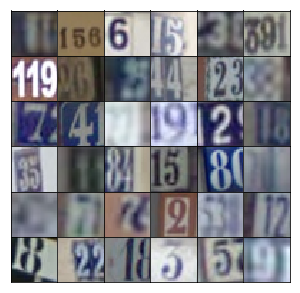

In [4]:
index = np.random.randint(0, training['X'].shape[3], size=36)

fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))
for i, ax in zip(index, axes.flatten()):
    ax.imshow(training['X'][:, :, :, i], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)

We can see these images are quite challenging because not all numbers are in the same resolution, nor porperly centered in the image, and also their lighting conditions vary.

In order to ease the learning process of our network, we must preprocess these images.

## Preprocessing

Let's create a data generator that also preprocesses the images in each batch it produces.

In [5]:
def scale(x, range=(-1, 1)):
    # Scale to (0, 1)
    x = (x - x.min()) / (x.max() - x.min())
    
    # Scare to input range
    minimum, maximum = range
    x = x * (maximum - minimum) + minimum
    return x

The SVHN dataset comes with a lot of labels, but in order to emulate a semi-supervised setting, we'll pretend there're only 1000 of them.


In [6]:
labeled = 1000

class Dataset(object):
    def __init__(self,
                 train, 
                 test, 
                 validation_proportion=0.5,
                 shuffle=False,
                 scale_function=None):
        split_index = int(len(test['y']) * (1 - validation_proportion))
        self.test_x = test['X'][:, :, :, :split_index]
        self.valid_x = test['X'][:, :, :, split_index:]
        
        self.test_y = test['y'][:split_index]
        self.valid_y = test['y'][split_index:]
        
        self.train_x = train['X']
        self.train_y = train['y']
        
        self.label_mask = np.zeros_like(self.train_y)
        self.label_mask[0:labeled] = 1
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_function is None:
            self.scaler = scale
        else:
            self.scaler = scale_function
                
        self.train_x = self.scaler(self.train_x)
        self.valid_x = self.scaler(self.valid_x)
        self.test_x = self.scaler(self.test_x)
        
        self.shuffle = shuffle
        
    def batches(self, batch_size, set_type='train'):
        x_name = set_type + '_x'
        y_name = set_type + '_y'
        
        number_of_examples = len(getattr(self, y_name))
        if self.shuffle:
            index = np.arange(number_of_examples)
            np.random.shuffle(index)
            
            setattr(self, x_name, getattr(self, x_name)[index])
            setattr(self, y_name, getattr(self, y_name)[index])
            
            if set_type == 'train':
                self.label_mask = self.label_mask[index]
                
        dataset_x = getattr(self, x_name)
        dataset_y = getattr(self, y_name)
            
        for i in range(0, number_of_examples, batch_size):
            x = dataset_x[i : i + batch_size]
            y = dataset_y[i : i + batch_size]
            
            if set_type == 'train':
                # We need to include the label mask to pretend we don't have enough
                # labeled data.
                yield x, y, self.label_mask[i: i + batch_size]
            else:
                yield x, y

## Architecture

We can now build the network. First, let's create some placeholders:

In [7]:
def model_inputs(input_dimensions, generated_dimensions):
    inputs_real = tf.placeholder(tf.float32, (None, *input_dimensions), name='input_real')
    inputs_generated = tf.placeholder(tf.float32, (None, generated_dimensions), name='input_generated')
    
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_generated, y, label_mask

### Generator

In [8]:
def generator(noise_input, output_dimensions, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(noise_input, (4 ** 3) * size_mult)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)  # This is the leaky ReLU.
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dimensions, 5, strides=2, padding='same')
        
        return tf.tanh(logits)  # Activation

### Discriminator

The discriminator has a lot more complexity this time. Given it must also classify, the network is deeper. 

In [9]:
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0, num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(x, rate=drop_rate / 2.5)
        
        
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(x1, size_mult, 3, strides=2, padding='same')
        # x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, size_mult, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(x3, 2 * size_mult, 3, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d(x4, 2 * size_mult, 3, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=True)
        x5 = tf.maximum(alpha * x5, x5)
        
        # x6 = tf.layers.conv2d(x5, 2 * size_mult, 3, strides=2, padding='same')
        # x6 = tf.layers.batch_normalization(x6, training=True)
        # x6 = tf.maximum(alpha * x6, x6)
        # x6 = tf.layers.dropout(x6, rate=drop_rate)
        
        x6 = tf.layers.conv2d(x5, 2 * size_mult, 3, strides=1, padding='valid')
        x6 = tf.maximum(alpha * x6, x6)
        
        # Flatten by global average pooling
        features = tf.reduce_mean(x6, (1, 2))
        class_logits = tf.layers.dense(features, num_classes + extra_class)
        
        if extra_class:
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, f'Wrong shape: {fake_class_logits.get_shape}'
            fake_class_logits = tf.squeeze(fake_class_logits)
        else:
            real_class_logits = class_logits
            fake_class_logits = 0.0
            
        maximum = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - maximum
        
        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(maximum) - fake_class_logits
        
        out = tf.nn.softmax(class_logits)
        
        return out, class_logits, gan_logits, features

Above, the `gan_logits` are set in a way that the conditional probability of the input bein real is the same as `sigmoid(gan_logits)`.

The `class_logits` give us the probability distribution over all the real **and** fake classes. 

For numerical stability we used a trick that defends us againt the situation where the activations are either largely negative or largely positive. (From line 47 to line 50)

## Loss

In [10]:
def model_loss(real_input, 
               generated_input, 
               output_dimensions, 
               y, 
               number_of_classes, 
               label_mask, 
               alpha=0.2, 
               drop_rate=0.0):
    generator_size_mult = 32
    discriminator_size_mult = 64
    
    generator_model = generator(generated_input, output_dimensions, alpha=alpha, size_mult=generator_size_mult)
    discriminator_on_data = discriminator(real_input, 
                                          alpha=alpha, 
                                          drop_rate=drop_rate,
                                          size_mult=discriminator_size_mult)
    real_discriminator_model, class_logits_on_data, gan_logits_on_data, data_features = discriminator_on_data
    
    discriminator_on_samples = discriminator(generator_model, 
                                             reuse=True, 
                                             alpha=alpha, 
                                             drop_rate=drop_rate, 
                                             size_mult=discriminator_size_mult)
    fake_discriminator_model, class_logits_on_samples, gan_logits_on_samples, sample_features = discriminator_on_samples
    
    
    
    real_discriminator_labels = tf.ones_like(gan_logits_on_data)
    real_discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_data, labels=real_discriminator_labels))

    fake_discriminator_labels = tf.zeros_like(gan_logits_on_samples)
    fake_discriminator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_samples, labels=fake_discriminator_labels))
    
    y = tf.squeeze(y)
    class_labels = tf.one_hot(y, number_of_classes + extra_class, dtype=tf.float32)
    class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_on_data, labels=class_labels)
    class_cross_entropy = tf.squeeze(class_cross_entropy)
    
    label_mask = tf.squeeze(tf.to_float(label_mask))
    
    discriminator_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1.0, tf.reduce_sum(label_mask))
    discriminator_loss = real_discriminator_loss + fake_discriminator_loss + discriminator_loss_class
    
    #####
    data_moments = tf.reduce_mean(data_features, axis=0)
    sample_moments = tf.reduce_mean(sample_features, axis=0)
    generator_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))
    
    predicted_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32)
    eq = tf.equal(tf.squeeze(y), predicted_class)
    correct = tf.reduce_sum(tf.to_float(eq))
    masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
    return discriminator_loss, generator_loss, correct, masked_correct, generator_model

Above we're computing the loss of the GAN problem (real vs. fake) and the loss of the multilabel classification of the SVHN dataset.

From line 43 on we use the "feature loss" invented by Tim Salimans at OpenAI, which consists of minimizing the absolute difference between the expected features on the data and the expected features on the generated samples.

This loss works better for semi-supervised learning than the traditional GAN loss.

## Optimizers

In [11]:
def model_optimizers(discriminator_loss, generator_loss, learning_rate, beta1):
    trainable_variables = tf.trainable_variables()
    discriminator_variables = [v for v in trainable_variables
                               if v.name.startswith('discriminator')]
    generator_variables = [v for v in trainable_variables
                            if v.name.startswith('generator')]
    
    
    discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(discriminator_loss, var_list=discriminator_variables)
    generator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(generator_loss, var_list=generator_variables)
    shrink_learning_rate = tf.assign(learning_rate, learning_rate * 0.9)
        
    return discriminator_optimizer, generator_optimizer, shrink_learning_rate

## Actual Model

Here we can use the functions defined in the previous cells to build the actual model

In [12]:
class DCGAN(object):
    def __init__(self, input_size, generated_size, learning_rate, number_of_classes=10, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        self.real_input, self.generated_input, self.y, self.label_mask = model_inputs(input_size, generated_size)
        self.drop_rate = tf.placeholder_with_default(0.5, (), 'drop_rate')
        
        loss_results = model_loss(self.real_input, 
                                  self.generated_input, 
                                  input_size[2], 
                                  self.y,
                                  number_of_classes, 
                                  label_mask=self.label_mask, 
                                  alpha=alpha,
                                  drop_rate=self.drop_rate)
        
        self.discriminator_loss, self.generator_loss, self.correct, self.masked_correct, self.samples = loss_results
        self.discriminator_optimizer, self.generator_optimizer, self.shrink_learning_rate = model_optimizers(self.discriminator_loss, 
                                                                                                             self.generator_loss, 
                                                                                                             self.learning_rate, 
                                                                                                             beta1)

The following function will allow us to display images easily:

In [13]:
def view_samples(epoch, samples, number_of_rows, number_of_cols, figsize=(5, 5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=number_of_rows, ncols=number_of_cols, sharey=True, sharex=True)
    
    for ax, image in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        image = ((image - image.min()) * 255 / (image.max() - image.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        image = ax.imshow(image, aspect='equal')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

Finally, here's a helper function to train the model.

In [14]:
def train(network, dataset, parameters, figsize=(5, 5), plot_samples=False):
    saver = tf.train.Saver()
    generated_sample = np.random.normal(0, 1, size=(50, parameters['generated_size']))
    
    samples = []
    train_accuracies = []
    test_accuracies = []
    steps = 0
    
    with tf.Session() as s:
        s.run(tf.global_variables_initializer())
        
        for epoch in range(parameters['epochs']):
            epoch_start_time = time.time()
            number_of_examples = 0
            number_correct = 0
            
            for x, y, label_mask in dataset.batches(parameters['batch_size']):
                steps += 1
                number_of_examples += label_mask.sum()
                
                generated_batch = np.random.normal(0, 1, size=(parameters['batch_size'], parameters['generated_size']))
                
                # Run optimizers
                step_start_time = time.time()
                _, _, correct = s.run([network.discriminator_optimizer,
                                       network.generator_optimizer,
                                       network.masked_correct], 
                                      feed_dict={
                        network.real_input: x,
                        network.generated_input: generated_batch,
                        network.y: y,
                        network.label_mask: label_mask
                    })
                step_end_time = time.time()
                number_correct += correct
            
            s.run([network.shrink_learning_rate])

            train_accuracy = number_correct / float(number_of_examples)
            
            print(f'Classifier train accuracy: {train_accuracy}')
            
            number_of_examples = 0
            number_correct = 0
            
            for x, y in dataset.batches(parameters['batch_size'], set_type='test'):
                number_of_examples += x.shape[0]
                correct, = s.run([network.correct], feed_dict={
                        network.real_input: x,
                        network.y: y,
                        network.drop_rate: 0.0
                    })
                number_correct += correct
                
            test_accuracy = number_correct / float(number_of_examples)
            print(f'Classifier test accuracy: {test_accuracy}')
            print(f'Step time: {step_end_time - step_start_time}')
            epoch_end_time = time.time()
            print(f'Epoch {epoch} time: {epoch_end_time - epoch_start_time}\n')
            
            gen_samples = s.run(network.samples, feed_dict={network.generated_input: generated_batch})
            samples.append(gen_samples)
            
            if plot_samples:
                _ = view_samples(-1, samples, 5, 10, figsize=figsize)
                plt.show()
            
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
        
        saver.save(s, './checkpoints/generator.ckpt')
    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
        
    return train_accuracies, test_accuracies, samples

### Hyperparameters

Hyperparameters are maybe the hardest part to get right about GANs, because we don't want any of the subnetworks overpowering the other.

In [15]:
input_size = (32, 32, 3)
learning_rate = 0.0003
alpha = 0.2
beta1 = 0.5

parameters = {
    'generated_size': 100,
    'epochs': 75,
    'batch_size': 64
}


network = DCGAN(input_size, parameters['generated_size'], learning_rate, alpha=alpha, beta1=beta1)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [16]:
dataset = Dataset(training, test)

train_accuracies, test_accuracies, samples = train(network, dataset, parameters, figsize=(10, 5))

Classifier train accuracy: 0.138
Classifier test accuracy: 0.1008758451137062
Step time: 0.07948589324951172
Epoch 0 time: 35.19270038604736

Classifier train accuracy: 0.155
Classifier test accuracy: 0.07375537799631224
Step time: 0.02918863296508789
Epoch 1 time: 33.970776081085205

Classifier train accuracy: 0.152
Classifier test accuracy: 0.18077750460971112
Step time: 0.02550029754638672
Epoch 2 time: 33.93558168411255

Classifier train accuracy: 0.222
Classifier test accuracy: 0.16863859864781808
Step time: 0.02566814422607422
Epoch 3 time: 33.000328063964844

Classifier train accuracy: 0.314
Classifier test accuracy: 0.25752919483712355
Step time: 0.03127479553222656
Epoch 4 time: 35.13062763214111

Classifier train accuracy: 0.363
Classifier test accuracy: 0.2941763982790412
Step time: 0.03209233283996582
Epoch 5 time: 35.86105942726135

Classifier train accuracy: 0.393
Classifier test accuracy: 0.2659035033804548
Step time: 0.03156113624572754
Epoch 6 time: 35.660539388656616


Classifier train accuracy: 0.748
Classifier test accuracy: 0.49938537185003073
Step time: 0.025612354278564453
Epoch 57 time: 33.08717131614685

Classifier train accuracy: 0.75
Classifier test accuracy: 0.5018438844499078
Step time: 0.025417804718017578
Epoch 58 time: 33.04369902610779

Classifier train accuracy: 0.75
Classifier test accuracy: 0.49953902888752305
Step time: 0.02544569969177246
Epoch 59 time: 33.06092143058777

Classifier train accuracy: 0.75
Classifier test accuracy: 0.501459741856177
Step time: 0.02542901039123535
Epoch 60 time: 32.98862957954407

Classifier train accuracy: 0.748
Classifier test accuracy: 0.4983097725875845
Step time: 0.025389671325683594
Epoch 61 time: 33.05436825752258

Classifier train accuracy: 0.751
Classifier test accuracy: 0.5006146281499693
Step time: 0.026601791381835938
Epoch 62 time: 33.11753559112549

Classifier train accuracy: 0.747
Classifier test accuracy: 0.5027658266748617
Step time: 0.025550127029418945
Epoch 63 time: 33.021955251693

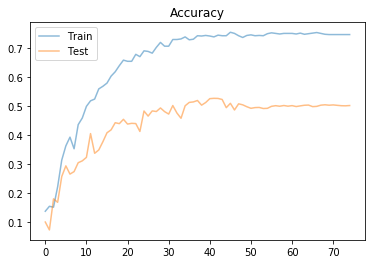

In [17]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title('Accuracy')
plt.legend()

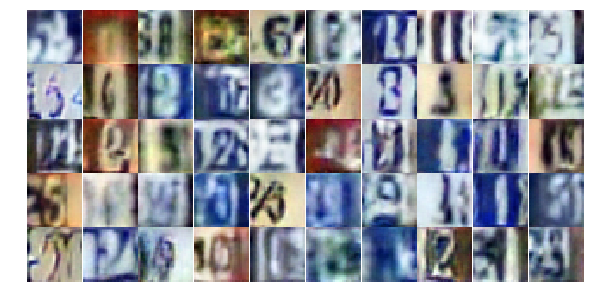

In [18]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))